#  Project 2 – Predictive Modeling 

In [47]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import imblearn
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# Complaints dataset from Consumer Financial Protection Bureau (CFPB)

In [48]:
# Step 2: Load the data
data = pd.read_csv('complaints_25Nov21.csv')
data = data.fillna('missing')

In [49]:
# Step 3:
data.shape

(207260, 18)

In [50]:
# Step 4: 
data

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,missing,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",missing,missing,missing,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",missing,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",missing,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,missing,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",missing,missing,missing,JPMORGAN CHASE & CO.,VA,22406,Servicemember,missing,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",missing,missing,missing,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,missing,missing,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,missing,missing,JPMORGAN CHASE & CO.,FL,33133,missing,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",missing,missing,missing,JPMORGAN CHASE & CO.,NY,10312,missing,missing,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,missing,missing,missing,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,missing,missing,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",missing,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,missing,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


In [51]:
# Step 5: Select relevant variables
X = data[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']]
y = data['Consumer disputed?']

In [52]:
# Step 6: Convert 'Consumer disputed?' to 0s and 1s
y = y.map({'Yes': 1, 'No': 0})
X_dummy = pd.get_dummies(X, columns=X.columns)

In [53]:
# Step 7: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.2, random_state=123)

In [54]:
# Step 8: Check the proportion of disputed complaints in the training dataset
proportion_disputed = y_train.mean()
if proportion_disputed < 0.3:
    # Perform random undersampling to balance the dataset
    from imblearn.under_sampling import RandomUnderSampler
    undersampler = RandomUnderSampler(random_state=123)
    X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [55]:
# Step 9: Train an XGBoost Classifier
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.53      0.65     32504
           1       0.27      0.63      0.38      8948

    accuracy                           0.55     41452
   macro avg       0.55      0.58      0.51     41452
weighted avg       0.72      0.55      0.59     41452



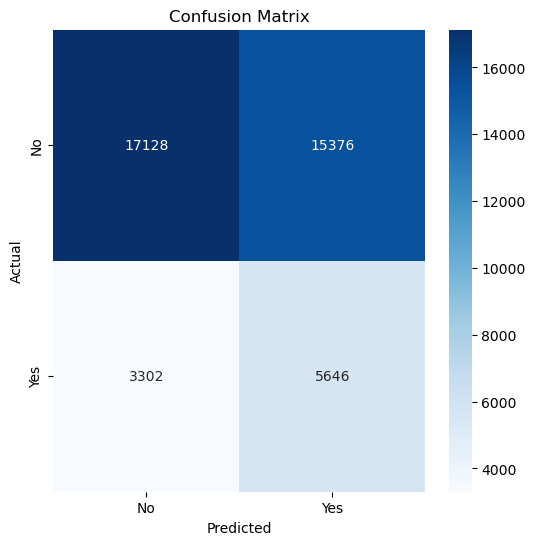

In [56]:
# Step 10: Evaluate the model on the test set
y_pred = model_xgb.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [57]:
# Step 11: Calculate the total cost in dollars for the test set
# Define cost parameters
base_cost_per_complaint = 100
extra_diligence_cost = 90
disputed_complaint_cost = 500

# Calculate the cost for each complaint in the test set
costs = []
for i in range(len(y_test)):
    if y_test.iloc[i] == 0:
        costs.append(base_cost_per_complaint)
    elif y_test.iloc[i] == 1 and y_pred[i] == 1:
        costs.append(base_cost_per_complaint + extra_diligence_cost)
    elif y_test.iloc[i] == 1 and y_pred[i] == 0:
        costs.append(base_cost_per_complaint + disputed_complaint_cost)

total_cost_base_case = sum(costs)

# Calculate the total cost based on the model results
total_cost_model = sum(costs)

In [58]:
# Step 12: Change the classification threshold to minimize total cost
thresholds = np.arange(0, 1.1, 0.1)
optimal_threshold = 0
optimal_cost = float('inf')

for threshold in thresholds:
    y_pred_adjusted = (model_xgb.predict_proba(X_test)[:, 1] > threshold).astype(int)
    adjusted_costs = [base_cost_per_complaint + extra_diligence_cost if y_test.iloc[i] == 1 and y_pred_adjusted[i] == 1
                      else base_cost_per_complaint + disputed_complaint_cost if y_test.iloc[i] == 1 and y_pred_adjusted[i] == 0
                      else base_cost_per_complaint for i in range(len(y_test))]
    total_adjusted_cost = sum(adjusted_costs)
    if total_adjusted_cost < optimal_cost:
        optimal_threshold = threshold
        optimal_cost = total_adjusted_cost

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Lowest Total Cost: ${optimal_cost}")

# You can now use the optimal threshold to make predictions for new complaints.

Optimal Threshold: 0.0
Lowest Total Cost: $4950520


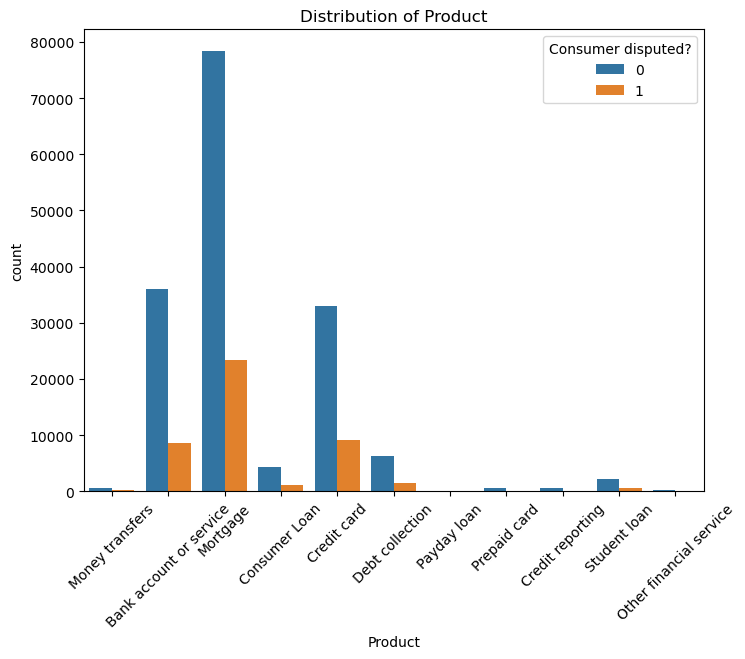

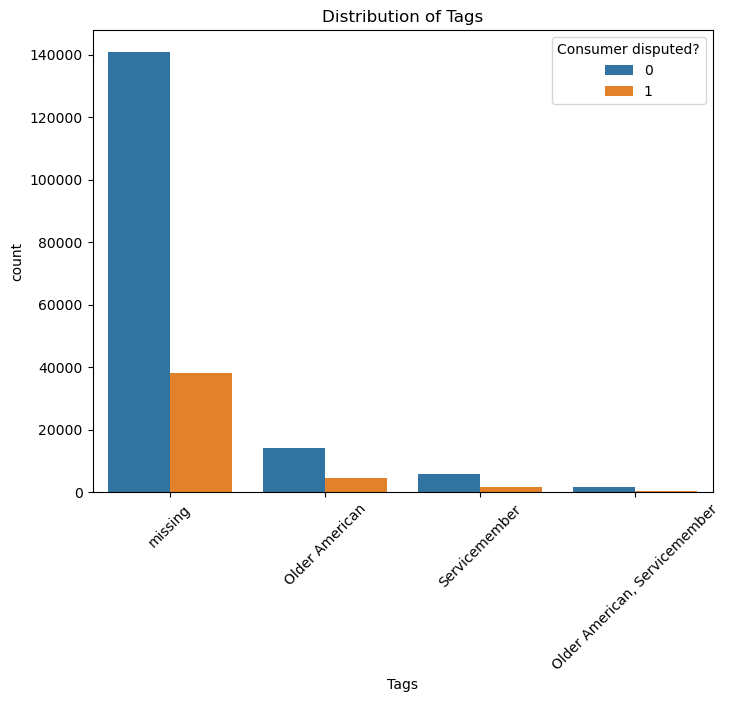

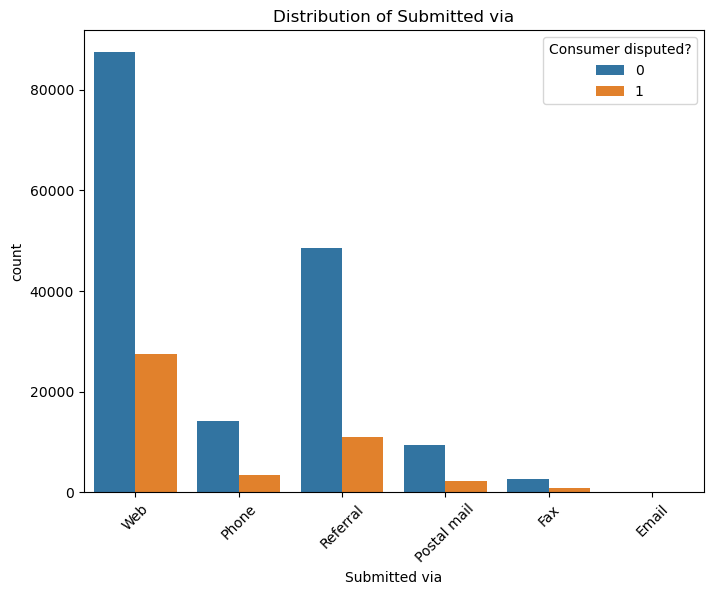

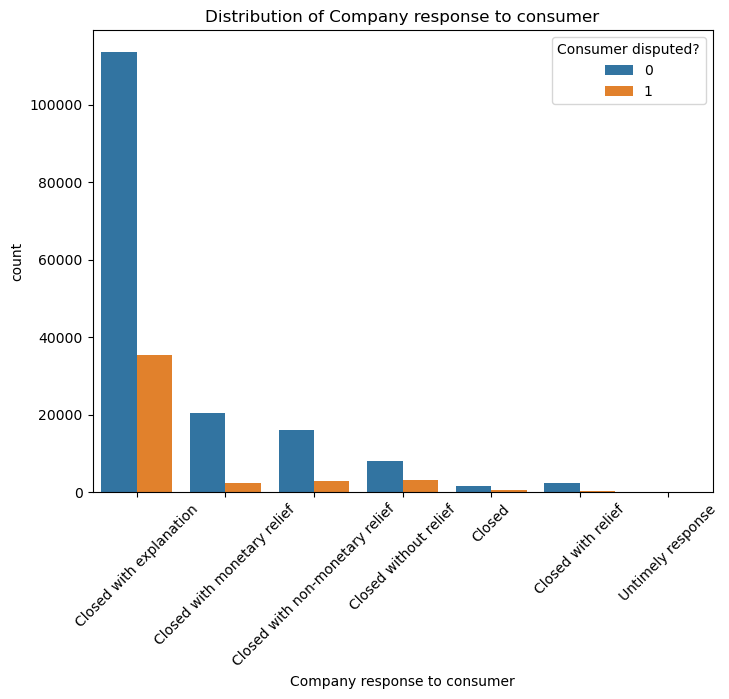

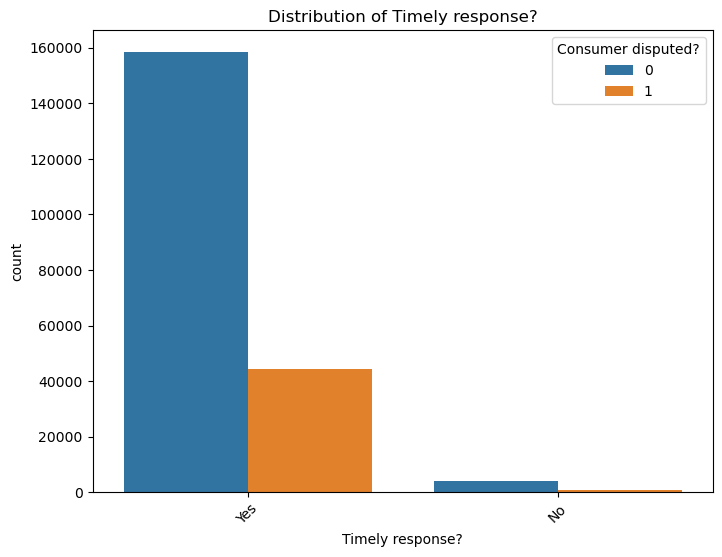

In [59]:
# Step 13: Univariate analysis
# Bar plots for categorical variables
selected_features = ['Product', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']

for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=feature, hue=y)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

# Q&A 

In [60]:
# Q1: Calculate the proportion of consumers who raised a dispute in the test set
proportion_disputed_test = y_test.mean()
print(f"Proportion of consumers who raised a dispute in the test set: {proportion_disputed_test:.6f}")

Proportion of consumers who raised a dispute in the test set: 0.215864


In [61]:
# Assuming that you have already performed random undersampling in your script
# Q2: Check the proportion of disputed complaints in the training dataset
proportion_disputed_undersampled = y_train.mean()
print(f"Proportion of consumers who raised a dispute in the undersampled training dataset: {proportion_disputed_undersampled:.6f}")


Proportion of consumers who raised a dispute in the undersampled training dataset: 0.500000


In [62]:
# Q3: Evaluate the model on the test set
y_pred = model_xgb.predict(X_test)

# Calculate the recall for the category 'Consumer disputed?' = 'Yes'
recall_yes = recall_score(y_test, y_pred, pos_label=1)

print(f"Recall for 'Consumer disputed?' = 'Yes' on the test set: {recall_yes:.6f}")

Recall for 'Consumer disputed?' = 'Yes' on the test set: 0.630979


In [63]:
# Q4: Define a function to calculate the cost of dealing with a complaint
def calculate_complaint_cost(complaint_row):
    # Replace this with your logic to calculate the cost
    # Example: if a complaint is costly and you have a cost associated with it
    if complaint_row['Consumer disputed?'] == 'Yes':
        return 600  # Replace 100 with the actual cost
    else:
        return 100  # Replace 50 with the actual cost for other complaints

# Replace 'your_test_set' with the actual name of your test set variable
test_set = data.sample(frac=0.2, random_state=123)  # Assuming a 20% test set split
test_set['Complaint Cost'] = test_set.apply(calculate_complaint_cost, axis=1)

# Calculate the total cost
cost_without_model = test_set['Complaint Cost'].sum()

print(f"Estimated total cost without a model: ${cost_without_model}")


Estimated total cost without a model: $8619200


Estimated total cost with a model : $7688180
[[17128 15376]
 [ 3302  5646]]


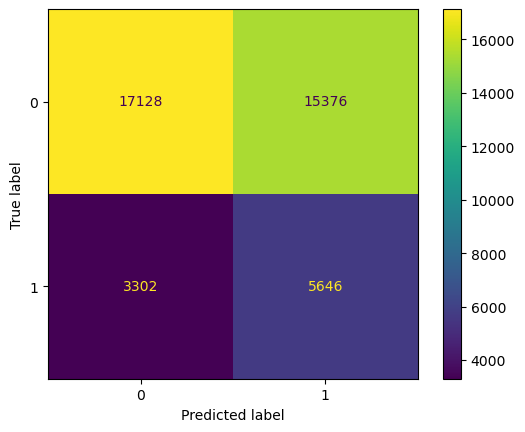

In [64]:
# Q5: Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate total cost
true_negatives, false_positives, false_negatives, true_positives = cm.ravel()

cost_with_model = (true_negatives*100) + ((true_positives+false_positives)*(100+90)) + (false_negatives*600)

print(f"Estimated total cost with a model : ${cost_with_model}")
print(cm)
# Display the confusion matrix using ConfusionMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix=cm)
# Plot the confusion matrix
display.plot()

In [70]:
# Q6 & 7: Initialize variables to keep track of the best threshold and lowest cost
best_threshold = 0
lowest_cost = float('inf')

# Iterate through different threshold values
for threshold in np.arange(0.1, 1.0, 0.1):  # Adjust the range and granularity as needed
    # Make predictions on the test set
    y_prob = model_xgb.predict_proba(X_test)
    # We drop the probabilities for class 0, and keep just the second column
    y_prob = y_prob[:,1]
    y_pred = (y_prob >= threshold).astype(int)  # Predict using the threshold

    # Calculate the confusion matrix
    confusion = confusion_matrix(y_test, y_pred)

    # Calculate total cost
    tn, fp, fn, tp = confusion.ravel()
    total_cost = ((tn*100) + ((tp+fp)*(100+90)) + (fn*600))

    # Check if this threshold results in a lower cost
    if total_cost < lowest_cost:
        lowest_cost = total_cost
        best_threshold = threshold
        
print(f"Best threshold for the lowest total cost: {best_threshold}")
print(f"Lowest total cost: ${lowest_cost}")

Best threshold for the lowest total cost: 0.4
Lowest total cost: $7615730
